In [1]:
!pip list

Package                Version            
---------------------- -------------------
absl-py                0.9.0              
alembic                1.4.1              
astor                  0.8.1              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.2              
bleach                 3.1.3              
blinker                1.4                
bokeh                  1.4.0              
cachetools             4.1.0              
certifi                2019.11.28         
certipy                0.1.3              
cffi                   1.14.0             
chardet                3.0.4              
click                  7.1.1              
cloudpickle            1.3.0              
conda                  4.8.2              
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
Cython     

In [2]:
import torch
# torchvisionはデータのロードや前(下?)処理に関する処理が入っている
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [3]:
# transform.Composeでデータロード後の前(下?)処理の関数を構成スる
transform = transforms.Compose(
    # torch.Tensorというテンソル型に変換する
    [transforms.ToTensor(),
     # Normalizeで第一引数のタプルが3チャネル(RGB)の平均を表す。第2引数のタプルが標準偏差。この2つで正規化する。
     transforms.Normalize((0.5, ), (0.5, ))])

# MNISTを読み込むやつ `root=`でディレクトリ指定
# train(True or False)で訓練用/テスト用をロード
# downloadでディレクトリに実際ダウンロードするか否か
trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)

# データをロードしてるみたい 1:データセット, 2:バッチサイズ, 3:epochごとにシャッフル, 4:サブプロセスでいくつ動かすのか
trainloader = torch.utils.data.DataLoader(trainset,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)

# MNISTのテストデータを読み込んでる
testset = torchvision.datasets.MNIST(root='./data', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=100,
                                            shuffle=False, 
                                            num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 引数は左から(インプットのチャネル数, アウトプットのチャネル数, カーネルサイズ(タプル入力で正方形以外も可能))
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        # ちなみに↑このCov2dの引数以降にストライド(default:1)とパディング(default:0)を設定できる
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64
        # p=0.5がデフォルト
        self.dropout1 = nn.Dropout2d()
        # ゆーたら全結合層 第一引数はチャネル数*最後のプーリング層の出力マップのサイズ
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 入力→conv1→relu→
        x = F.relu(self.conv1(x))
        # conv2→relu→pool→
        x = self.pool(F.relu(self.conv2(x)))
        # dropuot→
        x = self.dropout1(x)
        # 第一引数を-1, 第二引数の指定したサイズでテンソル行列へ変形してくれる
        x = x.view(-1, 12 * 12 * 64)
        # 全結合→relu→
        x = F.relu(self.fc1(x))
        # dropout→
        x = self.dropout2(x)
        # 全結合→
        x = self.fc2(x)
        return x
    
net = Net()

In [12]:
import torch.optim as optim

# 損失関数の定義 ソフトマックス公差エントロピー
criterion = nn.CrossEntropyLoss()
# SGD(確率的勾配降下法) lr:学習率, momentum: 摩擦係数的なw, 普通はAdam使う？
optimizer = optim.SGD(net.parameters(),
                      lr=0.0005, momentum=0.99, nesterov=True)

epochs = 3

for epoch in range(epochs):
    running_loss = 0.0
    # enumerateはインデックスの開始を第2引数で指定できる(これ0消していいんじゃないw)
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # zero the parameter gradients(勾配の初期化) 勾配が実行されるごとに加算
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # 自動微分！
        loss.backward()
        # パラメータの更新を行う
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[{:d}, {:5d}] loss: {:.3f}'
                    .format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.117
[1,   200] loss: 0.889
[1,   300] loss: 0.559
[1,   400] loss: 0.482
[1,   500] loss: 0.399
[1,   600] loss: 0.360
[2,   100] loss: 0.326
[2,   200] loss: 0.279
[2,   300] loss: 0.257
[2,   400] loss: 0.236
[2,   500] loss: 0.205
[2,   600] loss: 0.211
[3,   100] loss: 0.204
[3,   200] loss: 0.164
[3,   300] loss: 0.176
[3,   400] loss: 0.168
[3,   500] loss: 0.160
[3,   600] loss: 0.146
Finished Training


In [5]:
print(net)
params = list(net.parameters())
for param in params:
    print(param.size())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 9216])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [6]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [14]:
# for i, (inputs, labels) in enumerate(trainloader, 0):
    # print(inputs.size()) #torch.Size([100, 1, 28, 28]) バッチサイズとチャネル,W,H
    # print(labels) # 0~9のバッチのラベル?
    # print(i) # 0~600 恐らくバッチサイズが100なので600 * 100の60000データ数なのかな

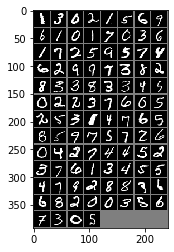

tensor([1, 3, 0, 2, 1, 5, 6, 9, 6, 1, 0, 1, 7, 0, 3, 6, 1, 7, 2, 5, 9, 5, 7, 4,
        6, 2, 9, 9, 7, 3, 8, 2, 8, 3, 3, 8, 3, 3, 4, 5, 0, 2, 2, 3, 7, 6, 0, 5,
        2, 5, 3, 1, 4, 7, 6, 5, 8, 5, 9, 7, 5, 7, 2, 6, 0, 4, 2, 7, 4, 4, 5, 2,
        3, 7, 6, 1, 3, 4, 5, 5, 4, 7, 9, 2, 8, 8, 3, 6, 6, 8, 2, 0, 0, 3, 5, 6,
        7, 3, 0, 5])


In [35]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 訓練データをランダムに取得
dataiter = iter(trainloader)
images, labels = dataiter.next()
# 画像の表示
imshow(torchvision.utils.make_grid(images))
print(labels)

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for (images, labels) in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: {:.2f} %%'.format(100 * float(correct/total)))

Accuracy: 95.93 %%


## Dropout

In [43]:
torch.cuda.is_available()
m = nn.Dropout2d(p=0.5)
input = torch.randn(3, 3)
output = m(input)
print(output)

tensor([[ 0.6639, -3.1253, -1.0637],
        [-0.5307, -0.0000, -0.0000],
        [ 0.0000, -0.0000,  2.4989]])


## 自動微分 backward

In [53]:
x = torch.tensor(4.0, requires_grad = True)
c = torch.tensor(8.0)
b = torch.tensor(5.0)
y = c*x + b*x**2

print(y)

tensor(112., grad_fn=<AddBackward0>)


In [54]:
y.backward()

In [55]:
print(x.grad)

tensor(48.)
